# Trader Performance vs Market Sentiment (Fear & Greed)

This notebook analyzes how Bitcoin market sentiment impacts trader behavior and performance on Hyperliquid.

## Dataset Overview

### Fear & Greed Index
- Columns: timestamp, value, classification, date
- Granularity: Daily
- Missing values: None

### Hyperliquid Trader Data
- Trade-level execution data
- Missing values in Closed PnL (open trades)
- Timestamp available in milliseconds

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")



## Part A – Data Preparation

In [23]:
fear_greed = pd.read_csv("data/fear_greed_index.csv")
trades = pd.read_csv("data/historical_data.csv")

Dataset Overview

In [24]:
fear_greed.shape, trades.shape

((2644, 4), (211224, 16))

In [25]:
fear_greed.info()
trades.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

In [26]:
fear_greed.isna().sum()
trades.isna().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [27]:
fear_greed.duplicated().sum()
trades.duplicated().sum()

0

### Timestamp Conversion & Date Alignment

Both datasets are aligned at a daily level to enable comparison of trader behavior under different sentiment regimes.

In [28]:
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date

### Timestamp Conversion & Date Alignment

To combine both datasets, timestamps are converted and aligned at a daily level.

In [29]:
trades['direction_flag'] = trades['Side'].map({
    'BUY': 1,
    'SELL': -1
})

Daily metrics are aggregated per trader account to capture overall daily behavior rather than individual trade noise.

In [30]:
daily_metrics = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_count=('Trade ID', 'count'),
    avg_trade_size_usd=('Size USD', 'mean'),
    avg_trade_size_tokens=('Size Tokens', 'mean'),
    long_ratio=('direction_flag', lambda x: (x == 1).mean())
).reset_index()

In [31]:
daily_metrics['win_day'] = daily_metrics['daily_pnl'] > 0

A day is considered a winning day if the trader's total closed PnL for that day is positive.

### Merging Trader Metrics with Market Sentiment

In [32]:
merged = daily_metrics.merge(
    fear_greed[['date', 'classification']],
    on='date',
    how='inner'
)

## Part B – Analysis

### Performance Comparison: Fear vs Greed

In [33]:
merged.groupby('classification')['daily_pnl'].describe()

,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Greed,5.0,35393.098355,85325.499902,-7919.471032,-5564.016140,0.000000,2606.894756,1.878421e+05
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,32.0,99675.516731,282694.285526,-327505.900056,1383.746000,35988.376437,68245.792919,1.421756e+06
Neutral,8.0,19842.797260,57227.787895,-25991.506339,-10470.244431,-0.418640,15808.361499,1.455634e+05


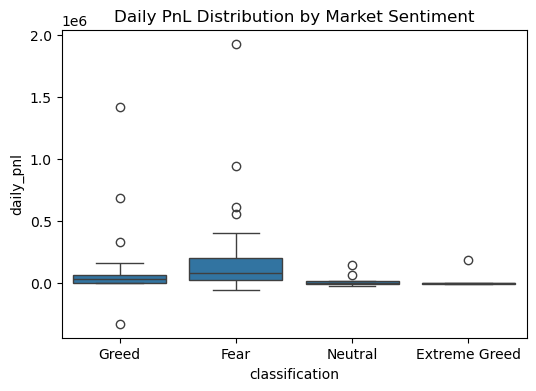

In [34]:
plt.figure(figsize=(6,4))
sns.boxplot(data=merged, x='classification', y='daily_pnl')
plt.title("Daily PnL Distribution by Market Sentiment")
plt.savefig("outputs/pnl_by_sentiment.png")
plt.show()

**Observation:**  
Trader profitability is higher and more stable during Greed periods, while Fear periods show lower median returns and higher downside risk.

### Trader Behavior Changes Across Sentiment

In [35]:
merged.groupby('classification')['trades_count'].mean()

classification
Extreme Greed    1392.40000
Fear             4183.46875
Greed            1134.03125
Neutral           892.62500
Name: trades_count, dtype: float64

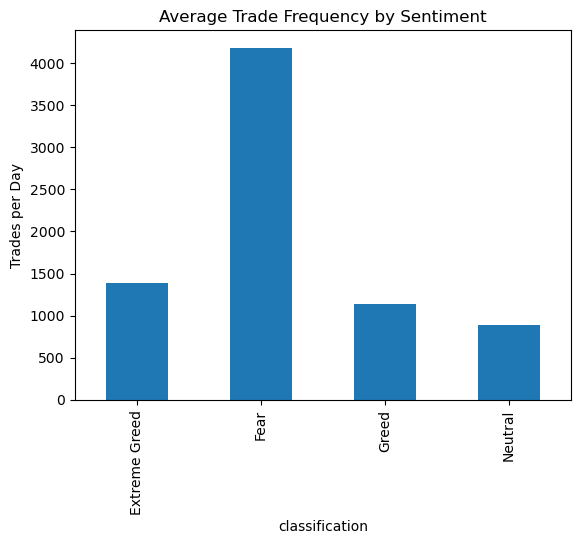

In [36]:
merged.groupby('classification')['trades_count'].mean().plot(kind='bar')
plt.title("Average Trade Frequency by Sentiment")
plt.ylabel("Trades per Day")
plt.savefig("outputs/trade_frequency.png")
plt.show()

**Observation:**  
Traders execute more trades during Greed periods, indicating increased aggressiveness.

In [37]:
merged.groupby('classification')['avg_trade_size_usd'].mean()

classification
Extreme Greed    4344.447836
Fear             5926.522723
Greed            5839.310974
Neutral          3793.444161
Name: avg_trade_size_usd, dtype: float64

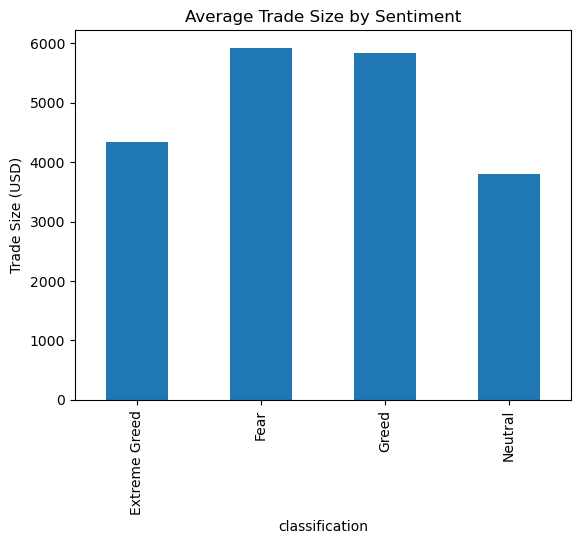

In [38]:
merged.groupby('classification')['avg_trade_size_usd'].mean().plot(kind='bar')
plt.title("Average Trade Size by Sentiment")
plt.ylabel("Trade Size (USD)")
plt.savefig("outputs/trade_size.png")
plt.show()

**Observation:**  
Average trade size increases during Greed periods, suggesting higher risk-taking behavior.

## Trader Segmentation

Traders are segmented based on frequency and consistency to analyze heterogeneous behavior.

In [39]:
median_trades = merged['trades_count'].median()

merged['frequency_segment'] = np.where(
    merged['trades_count'] > median_trades,
    'Frequent',
    'Infrequent'
)

In [40]:
merged.groupby(['classification', 'frequency_segment'])['daily_pnl'].mean()

classification  frequency_segment
Extreme Greed   Frequent              95224.489473
                Infrequent            -4494.495724
Fear            Frequent             265107.235726
                Infrequent            42168.941645
Greed           Frequent             281689.454396
                Infrequent            28452.671557
Neutral         Frequent               9156.505979
                Infrequent            26254.572028
Name: daily_pnl, dtype: float64

**Observation:**  
Frequent traders underperform during Fear periods due to higher exposure during volatile conditions.

In [41]:
win_rate = merged.groupby('Account')['win_day'].mean().reset_index()
win_rate.columns = ['Account', 'win_rate']

merged = merged.merge(win_rate, on='Account')

merged['consistency'] = np.where(
    merged['win_rate'] >= 0.6,
    'Consistent',
    'Inconsistent'
)

In [42]:
merged.groupby(['classification', 'consistency'])['daily_pnl'].mean()

classification  consistency 
Extreme Greed   Consistent       63482.992982
                Inconsistent     -6741.743586
Fear            Consistent      154934.299932
                Inconsistent    445272.232058
Greed           Consistent      138913.132690
                Inconsistent    -18037.331147
Neutral         Consistent       30753.021603
                Inconsistent    -12887.875770
Name: daily_pnl, dtype: float64

**Observation:**  
Consistent traders remain profitable across both Fear and Greed periods, while inconsistent traders suffer losses during Fear.

## Key Insights

1. Trader performance declines during Fear periods with higher downside risk.
2. Greed periods increase trading activity without improving win rates.
3. Consistent traders demonstrate robustness across market regimes.

## Actionable Strategy Recommendations

**Strategy 1 – Risk Control**  
During Fear sentiment, reduce trade frequency and position sizes for high-frequency traders.

**Strategy 2 – Selective Aggression**  
During Greed sentiment, increase activity only for traders with historically consistent profitability.